# PACMANN Data Wrangling Project – 2017 Product Analysis

## Objectives

In this project, we are going to identify which categories of products

- bring the largest sales
- are sold the most
- have the largest number of customers
- are usually bought in bundles (more than one per order)
- have the highest review score
- have the highest share of unsold products

in the year 2017.

# 0. Initialisation

In [1]:
# loading in modules
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# creating file path
dbfile = 'olist.db'
# Create a SQL connection to our SQLite database
con = sqlite3.connect(dbfile)

# creating cursor
cur = con.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

con.close()

[('olist_order_customer_dataset',), ('olist_order_dataset',), ('olist_order_reviews_dataset',), ('olist_order_payments_dataset',), ('olist_order_items_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('olist_geolocation_dataset',), ('product_category_name_translation',)]


In [2]:
def get_result(query):
    # a function to query from database
    dbfile = 'olist.db'
    conn = sqlite3.connect(dbfile)
    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    cur.execute(query)
    data = pd.read_sql_query(query, con)
    con.close()
    return data

# 1. Querying the Necessary Data

To get a table of data consisting of the product descriptions (category, product id), sales, and review score, all in the year 2017 (at the time the order was created), we are going to query from the tables 

- olist_order_items_dataset
- olist_order_dataset
- olist_order_reviews_dataset
- olist_order_customer_dataset

Note: In the original olist_order_reviews_dataset table, there is really no product identification (only order_id identification), so for orders with more than 1 item, there is no column identifying which product is being reviewed. Due to this, we just assume that the reviewer’s score for the product is the mean review score out of all scores within the order.

In [3]:
query = '''
WITH agg_products_1 AS(
SELECT
order_id,
product_id,
customer_unique_id,
SUM(price) AS total_price,
COUNT(order_id) AS num_sold,
CASE WHEN COUNT(order_id) > 1 THEN 1
ELSE 0 
END more_than_one,
AVG(review_score) AS review_score
FROM olist_order_items_dataset
LEFT JOIN olist_order_dataset USING(order_id)
LEFT JOIN olist_order_reviews_dataset USING(order_id)
LEFT JOIN olist_order_customer_dataset USING(customer_id)
WHERE DATE(order_purchase_timestamp) <= DATE('2017-12-31') 
AND DATE(order_purchase_timestamp) >= DATE('2017-01-01')
AND order_status = 'delivered'
GROUP BY order_id, product_id
),

agg_products_2 AS(
SELECT
product_id,
SUM(total_price) AS sales,
SUM(num_sold) AS total_sold,
COUNT(order_id) AS num_orders,
SUM(more_than_one) AS num_times_more_than_one,
COUNT(DISTINCT customer_unique_id) AS num_uniq_customers,
AVG(review_score) AS mean_review_score
FROM agg_products_1
GROUP BY product_id
)

SELECT
product_category_name_english,
product_category_name,
product_id,
sales,
total_sold,
num_orders,
num_times_more_than_one,
num_uniq_customers,
mean_review_score
FROM olist_products_dataset
LEFT JOIN agg_products_2 USING(product_id)
LEFT JOIN product_category_name_translation USING(product_category_name)
'''

product_2017 = get_result(query)

In [4]:
product_2017.head()

,product_category_name_english,product_category_name,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score
0,perfumery,perfumaria,1e9e8ef04dbcff4541ed26657ea517e5,NaN,NaN,NaN,NaN,NaN,NaN
1,art,artes,3aa071139cb16b67ca9e5dea641aaa2f,NaN,NaN,NaN,NaN,NaN,NaN
2,sports_leisure,esporte_lazer,96bd76ec8810374ed1b65e291975717f,NaN,NaN,NaN,NaN,NaN,NaN
3,baby,bebes,cef67bcfe19066a932b7673e239eb23d,NaN,NaN,NaN,NaN,NaN,NaN
4,housewares,utilidades_domesticas,9dc1a7de274444849c219cff195d0b71,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
product_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_category_name_english  32328 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_id                     32951 non-null  object 
 3   sales                          16803 non-null  float64
 4   total_sold                     16803 non-null  float64
 5   num_orders                     16803 non-null  float64
 6   num_times_more_than_one        16803 non-null  float64
 7   num_uniq_customers             16803 non-null  float64
 8   mean_review_score              16716 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.3+ MB


In [6]:
# Impute NaN-valued sales, total_sold, and num_times_more_than_one, and num_uniq_customers with 0
# because it meant those products weren't sold in 2017

col = ['sales', 'total_sold', 'num_orders', 'num_times_more_than_one', 'num_uniq_customers']

for column in col:
    product_2017[col] = product_2017[col].fillna(value=0)

product_2017 = product_2017.reset_index(drop=True)

In [7]:
product_2017

,product_category_name_english,product_category_name,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score
0,perfumery,perfumaria,1e9e8ef04dbcff4541ed26657ea517e5,0.00,0.0,0.0,0.0,0.0,NaN
1,art,artes,3aa071139cb16b67ca9e5dea641aaa2f,0.00,0.0,0.0,0.0,0.0,NaN
2,sports_leisure,esporte_lazer,96bd76ec8810374ed1b65e291975717f,0.00,0.0,0.0,0.0,0.0,NaN
3,baby,bebes,cef67bcfe19066a932b7673e239eb23d,0.00,0.0,0.0,0.0,0.0,NaN
4,housewares,utilidades_domesticas,9dc1a7de274444849c219cff195d0b71,0.00,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
32946,furniture_decor,moveis_decoracao,a0b7d5a992ccda646f2d34e418fff5a0,69.90,1.0,1.0,0.0,1.0,2.0
32947,construction_tools_lights,construcao_ferramentas_iluminacao,bf4538d88321d0fd4412a93c974510e6,0.00,0.0,0.0,0.0,0.0,NaN
32948,bed_bath_table,cama_mesa_banho,9a7c6041fa9592d9d9ef6cfe62a71f8c,127.50,1.0,1.0,0.0,1.0,5.0
32949,computers_accessories,informatica_acessorios,83808703fc0706a22e264b9d75f04a2e,79.42,2.0,1.0,1.0,1.0,5.0


# 2. Cleaning the Data

In [8]:
product_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_category_name_english  32328 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_id                     32951 non-null  object 
 3   sales                          32951 non-null  float64
 4   total_sold                     32951 non-null  float64
 5   num_orders                     32951 non-null  float64
 6   num_times_more_than_one        32951 non-null  float64
 7   num_uniq_customers             32951 non-null  float64
 8   mean_review_score              16716 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.3+ MB


There are null values in product_category_name_english, product_category_name, and mean_review_score.

In [9]:
product_2017_copy = product_2017.copy()

## (2a) Cleaning product_category_name_english

First, we check whether there are rows with defined 'product_category_name' but NaN 'product_category_name_english' (or otherwise)

In [10]:
null_english = product_2017_copy['product_category_name_english'].isna()
valid_category_name = ~(product_2017_copy['product_category_name'].isna())

product_2017_copy[null_english & valid_category_name]

,product_category_name_english,product_category_name,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score
1628,None,pc_gamer,0105b5323d24fc655f73052694dbbb3a,519.96,4.0,4.0,0.0,4.0,3.5
5821,None,portateis_cozinha_e_preparadores_de_alimentos,6fd83eb3e0799b775e4f946bd66657c0,0.00,0.0,0.0,0.0,0.0,NaN
7325,None,portateis_cozinha_e_preparadores_de_alimentos,5d923ead886c44b86845f69e50520c3e,0.00,0.0,0.0,0.0,0.0,NaN
7478,None,pc_gamer,6727051471a0fc4a0e7737b57bff2549,0.00,0.0,0.0,0.0,0.0,NaN
8819,None,portateis_cozinha_e_preparadores_de_alimentos,bed164d9d628cf0593003389c535c6e0,0.00,0.0,0.0,0.0,0.0,NaN
11039,None,portateis_cozinha_e_preparadores_de_alimentos,1220978a08a6b29a202bc015b18250e9,0.00,0.0,0.0,0.0,0.0,NaN
14266,None,portateis_cozinha_e_preparadores_de_alimentos,ae62bb0f95af63d64eae5f93dddea8d3,0.00,0.0,0.0,0.0,0.0,NaN
16182,None,portateis_cozinha_e_preparadores_de_alimentos,1954739d84629e7323a4295812a3e0ec,0.00,0.0,0.0,0.0,0.0,NaN
16930,None,pc_gamer,dbe520fb381ad695a7e1f2807d20c765,0.00,0.0,0.0,0.0,0.0,NaN
17800,None,portateis_cozinha_e_preparadores_de_alimentos,c7a3f1a7f9eef146cc499368b578b884,0.00,0.0,0.0,0.0,0.0,NaN


In [11]:
product_2017_copy[~null_english & ~valid_category_name]

,product_category_name_english,product_category_name,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score


In [12]:
# Fill the row with NaN product_category_name_english but valid product_category_name

pc_gamer_port = (product_2017_copy['product_category_name'] == 'pc_gamer')

product_2017_copy.loc[null_english & pc_gamer_port,'product_category_name_english'] = 'pc_gamer'

product_2017_copy.loc[null_english & valid_category_name & ~pc_gamer_port,'product_category_name_english'] = 'kitchen_racks'

In [13]:
product_2017_copy[null_english & valid_category_name]

,product_category_name_english,product_category_name,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score
1628,pc_gamer,pc_gamer,0105b5323d24fc655f73052694dbbb3a,519.96,4.0,4.0,0.0,4.0,3.5
5821,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,6fd83eb3e0799b775e4f946bd66657c0,0.00,0.0,0.0,0.0,0.0,NaN
7325,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,5d923ead886c44b86845f69e50520c3e,0.00,0.0,0.0,0.0,0.0,NaN
7478,pc_gamer,pc_gamer,6727051471a0fc4a0e7737b57bff2549,0.00,0.0,0.0,0.0,0.0,NaN
8819,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,bed164d9d628cf0593003389c535c6e0,0.00,0.0,0.0,0.0,0.0,NaN
11039,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,1220978a08a6b29a202bc015b18250e9,0.00,0.0,0.0,0.0,0.0,NaN
14266,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,ae62bb0f95af63d64eae5f93dddea8d3,0.00,0.0,0.0,0.0,0.0,NaN
16182,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,1954739d84629e7323a4295812a3e0ec,0.00,0.0,0.0,0.0,0.0,NaN
16930,pc_gamer,pc_gamer,dbe520fb381ad695a7e1f2807d20c765,0.00,0.0,0.0,0.0,0.0,NaN
17800,kitchen_racks,portateis_cozinha_e_preparadores_de_alimentos,c7a3f1a7f9eef146cc499368b578b884,0.00,0.0,0.0,0.0,0.0,NaN


Now let's fill other NaN 'product_category_name_english' with 'unknown'

In [14]:
product_2017_copy.loc[:,'product_category_name_english'].fillna('unknown', inplace=True)

In [15]:
# Drop product_category_name as it's in Portuguese

product_2017_copy.drop(columns='product_category_name', inplace=True)

# Change product_category_name_english column name

product_2017_copy.rename(columns = {'product_category_name_english': 'product_category'},
                         inplace = True)

In [16]:
product_2017_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_category         32951 non-null  object 
 1   product_id               32951 non-null  object 
 2   sales                    32951 non-null  float64
 3   total_sold               32951 non-null  float64
 4   num_orders               32951 non-null  float64
 5   num_times_more_than_one  32951 non-null  float64
 6   num_uniq_customers       32951 non-null  float64
 7   mean_review_score        16716 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.0+ MB


In [17]:
product_2017_copy['product_category'].unique()

array(['perfumery', 'art', 'sports_leisure', 'baby', 'housewares',
       'musical_instruments', 'cool_stuff', 'furniture_decor',
       'home_appliances', 'toys', 'bed_bath_table',
       'construction_tools_safety', 'computers_accessories',
       'health_beauty', 'luggage_accessories', 'garden_tools',
       'office_furniture', 'auto', 'electronics', 'fashion_shoes',
       'telephony', 'stationery', 'fashion_bags_accessories', 'computers',
       'home_construction', 'watches_gifts',
       'construction_tools_construction', 'pet_shop', 'small_appliances',
       'agro_industry_and_commerce', 'unknown', 'furniture_living_room',
       'signaling_and_security', 'air_conditioning', 'consoles_games',
       'books_general_interest', 'costruction_tools_tools',
       'fashion_underwear_beach', 'fashion_male_clothing',
       'kitchen_dining_laundry_garden_furniture',
       'industry_commerce_and_business', 'fixed_telephony',
       'construction_tools_lights', 'books_technical',
     

In [18]:
product_2017_copy['product_category'].unique().shape

(74,)

## (2b) Cleaning product_category: category shrinking

In [19]:
# fashion category

cat_0 = 'fashion'
group_0 = ['fashio']

for cat_name in group_0:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_0 if cat_name in x else x)

In [20]:
# home & furniture

cat_1 = 'home, furniture & appliances'
group_1 = ['home', 'furniture', 'housewares', 'appliances', 
           'bed_bath_table', 'air_conditioning', 'flowers', 'kitchen']

for cat_name in group_1:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_1 if cat_name in x else x)

In [21]:
# food & drink

cat_2 = 'food & drink'
group_2 = ['food', 'drink', 'cuisine']

for cat_name in group_2:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_2 if cat_name in x else x)

In [22]:
# computer stuffs

cat_3 = 'PC, electronics & accessories'
group_3 = ['computers', 'pc', 'dvds', 'cds', 'audio', 
           'tablets', 'game', 'electronics', 'music', 'telephony']

for cat_name in group_3:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_3 if cat_name in x else x)

In [23]:
# health & beauty stuffs

cat_4 = "health, beauty & hygiene"
group_4 = ['perfumery', 'baby', 'health', 'beauty', 'hygiene', 'sports']

for cat_name in group_4:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_4 if cat_name in x else x)

In [24]:
# books

cat_5 = 'books'
group_5 = ['books']

for cat_name in group_5:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_5 if cat_name in x else x)

In [25]:
# construction tools

cat_6 = 'construction & garden tools'
group_6 = ['garden_tools', 'construction_tools', 'costruction_tools']

for cat_name in group_6:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_6 if cat_name in x else x)

In [26]:
# stationery stuffs

cat_7 = 'toys, arts, craftmanship, stationery & accessories'
group_7 = ['toys', 'art', 'stationery', 'supplies', 'cine_photo']

for cat_name in group_7:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_7 if cat_name in x else x)

In [27]:
# security 

cat_8 = 'security'
group_8 = ['security']

for cat_name in group_8:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_8 if cat_name in x else x)

In [28]:
# industry & commerce

cat_9 = 'industry & commerce'
group_9 = ['industry', 'commerce', 'market']

for cat_name in group_9:
    product_2017_copy['product_category'] = product_2017_copy['product_category'].apply(lambda x: cat_9 if cat_name in x else x)

In [29]:
product_2017_copy['product_category'].unique()

array(['health, beauty & hygiene',
       'toys, arts, craftmanship, stationery & accessories',
       'home, furniture & appliances', 'PC, electronics & accessories',
       'cool_stuff', 'construction & garden tools', 'luggage_accessories',
       'auto', 'fashion', 'watches_gifts', 'pet_shop',
       'industry & commerce', 'unknown', 'security', 'books',
       'food & drink'], dtype=object)

In [30]:
product_2017_copy['product_category'].unique().shape

(16,)

In [31]:
product_2017_copy

,product_category,product_id,sales,total_sold,num_orders,num_times_more_than_one,num_uniq_customers,mean_review_score
0,"health, beauty & hygiene",1e9e8ef04dbcff4541ed26657ea517e5,0.00,0.0,0.0,0.0,0.0,NaN
1,"toys, arts, craftmanship, stationery & accesso...",3aa071139cb16b67ca9e5dea641aaa2f,0.00,0.0,0.0,0.0,0.0,NaN
2,"health, beauty & hygiene",96bd76ec8810374ed1b65e291975717f,0.00,0.0,0.0,0.0,0.0,NaN
3,"health, beauty & hygiene",cef67bcfe19066a932b7673e239eb23d,0.00,0.0,0.0,0.0,0.0,NaN
4,"home, furniture & appliances",9dc1a7de274444849c219cff195d0b71,0.00,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
32946,"home, furniture & appliances",a0b7d5a992ccda646f2d34e418fff5a0,69.90,1.0,1.0,0.0,1.0,2.0
32947,construction & garden tools,bf4538d88321d0fd4412a93c974510e6,0.00,0.0,0.0,0.0,0.0,NaN
32948,"home, furniture & appliances",9a7c6041fa9592d9d9ef6cfe62a71f8c,127.50,1.0,1.0,0.0,1.0,5.0
32949,"PC, electronics & accessories",83808703fc0706a22e264b9d75f04a2e,79.42,2.0,1.0,1.0,1.0,5.0


## (2c) Cleaning mean_review_score

First, we look at the distribution of mean_review_score

<AxesSubplot:xlabel='mean_review_score', ylabel='Count'>

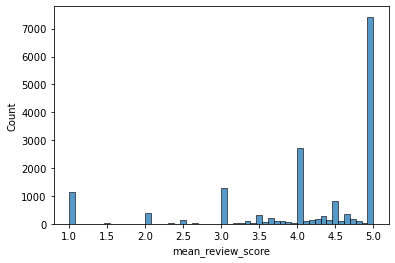

In [32]:
sns.histplot(data=product_2017_copy, x='mean_review_score')

In [32]:
# proportion of unsold products 

never_sold = product_2017_copy['total_sold']==0

print(f'Probability of unsold products = {never_sold.mean()}')

Probability of unsold products = 0.490060999666171


In [33]:
# proportion of products sold only once

ordered_once = product_2017_copy['total_sold']==1

ordered_once.mean()

print(f'Probability of sold products = {ordered_once.mean()}')

Probability of sold products = 0.2888531455798003


In [34]:
# probability of a product is sold only once, given that the product is actually sold

p = ordered_once.mean()/(~never_sold).mean()

print(f'Probability of products sold only once, given they are sold = {p}')

Probability of products sold only once, given they are sold = 0.5664464678926382


In [35]:
# We impute missing values of mean_review_score of SOLD products with the median

review_median = product_2017_copy['mean_review_score'].median()
product_2017_copy.loc[~never_sold, 'mean_review_score'] = product_2017_copy.loc[~never_sold, 'mean_review_score'].fillna(review_median)

In [36]:
product_2017_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_category         32951 non-null  object 
 1   product_id               32951 non-null  object 
 2   sales                    32951 non-null  float64
 3   total_sold               32951 non-null  float64
 4   num_orders               32951 non-null  float64
 5   num_times_more_than_one  32951 non-null  float64
 6   num_uniq_customers       32951 non-null  float64
 7   mean_review_score        16803 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.0+ MB


In [37]:
product_2017_copy[~never_sold].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16803 entries, 6 to 32949
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_category         16803 non-null  object 
 1   product_id               16803 non-null  object 
 2   sales                    16803 non-null  float64
 3   total_sold               16803 non-null  float64
 4   num_orders               16803 non-null  float64
 5   num_times_more_than_one  16803 non-null  float64
 6   num_uniq_customers       16803 non-null  float64
 7   mean_review_score        16803 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.2+ MB


# 3. Aggregating

In [44]:
product_2017_copy['unsold'] = np.where((product_2017_copy['total_sold']==0), 1, 0)

In [128]:
product_agg = product_2017_copy.copy()
#product_agg.drop(columns='product_id', inplace=True)

agg = {'product_id': 'count',
       'unsold': 'mean',
       'sales': 'sum',
       'total_sold': 'sum',
       'num_orders': 'sum',
       'num_times_more_than_one': 'sum',
       'num_uniq_customers': 'mean',
       'mean_review_score': 'median'}

product_agg = product_agg.groupby('product_category').agg(agg)

product_agg.rename(columns = {'product_id': 'num_products',
                             'unsold': 'unsold_products_proportion',
                             'sales': 'total_sales',
                             'num_orders': 'total_orders',
                             'num_times_more_than_one': 'total_times_more_than_one',
                             'num_uniq_customers': 'mean_uniq_customers',
                             'mean_review_score': 'median_of_mean_review_score'}, inplace = True)

In [129]:
product_agg

,num_products,unsold_products_proportion,total_sales,total_sold,total_orders,total_times_more_than_one,mean_uniq_customers,median_of_mean_review_score
product_category,,,,,,,,
"PC, electronics & accessories",4188,0.449618,961359.22,7559.0,6856.0,493.0,1.629895,4.500000
auto,1900,0.626316,234815.93,1560.0,1431.0,80.0,0.751579,4.633333
books,370,0.629730,25156.21,287.0,275.0,7.0,0.743243,5.000000
construction & garden tools,1449,0.617667,301690.24,2706.0,2224.0,343.0,1.528640,4.750000
cool_stuff,789,0.286439,382522.07,2271.0,2181.0,70.0,2.761724,4.555556
fashion,1221,0.303849,113810.01,1550.0,1487.0,53.0,1.212121,4.569444
food & drink,277,0.588448,21722.15,341.0,291.0,32.0,1.039711,4.888889
"health, beauty & hygiene",7110,0.514487,1276311.86,10598.0,9799.0,603.0,1.371589,4.666667
"home, furniture & appliances",9846,0.488015,1477225.82,14633.0,12579.0,1441.0,1.272903,4.333333


In [130]:
product_agg['proportion_num_times_more_than_one'] = product_agg['total_times_more_than_one']/product_agg['total_orders']

product_agg['sales_per_orders'] = product_agg['total_sales']/product_agg['total_orders']

product_agg['sales_per_products'] = product_agg['total_sales']/product_agg['num_products']

In [131]:
product_agg.reset_index(inplace=True)

In [115]:
pip install colorcet

Note: you may need to restart the kernel to use updated packages.


In [124]:
category = product_agg['product_category']

import colorcet as cc

color = sns.color_palette(cc.glasbey, n_colors=len(category))

dict_color = {col:color[n] for n, col in enumerate(category)}

In [125]:
color

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (0.3411764705882353, 0.23137254901960785, 0.0),
 (0.0, 0.33725490196078434, 0.34901960784313724),
 (0.0, 0.0, 0.8666666666666667),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6313725490196078, 0.4588235294117647, 0.4117647058823529),
 (0.7372549019607844, 0.7137254901960784, 1.0),
 (0.5843137254901961, 0.7098039215686275, 0.4666666666666667),
 (0.7490196078431373, 0.011764705882352941, 0.7215686274509804)]

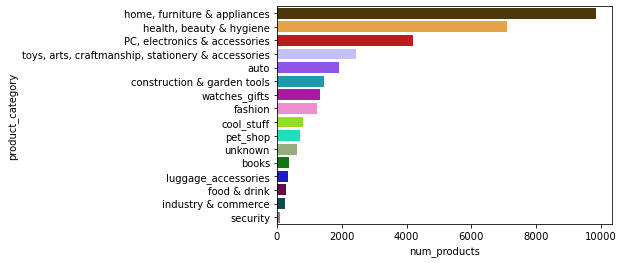

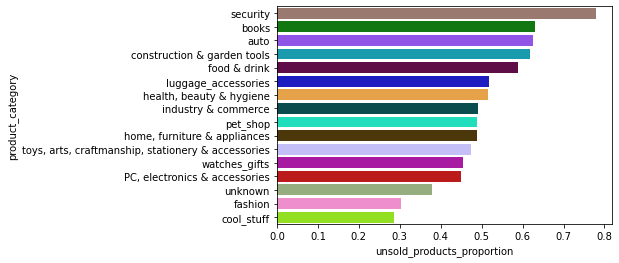

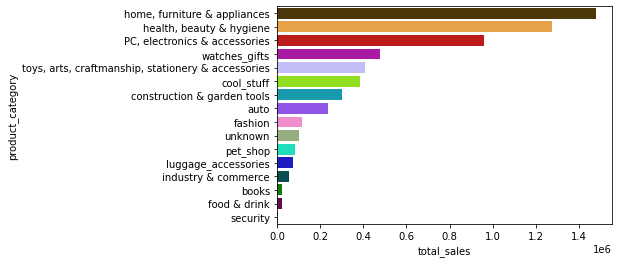

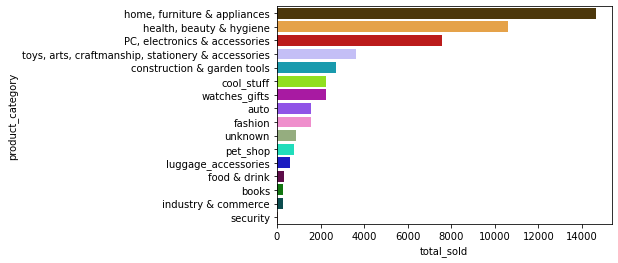

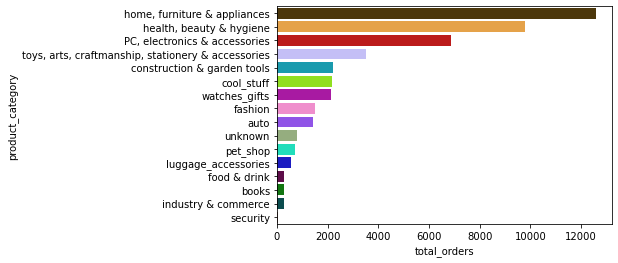

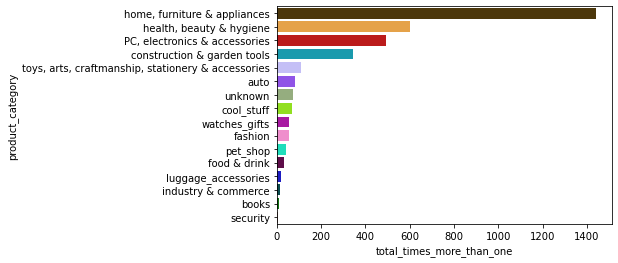

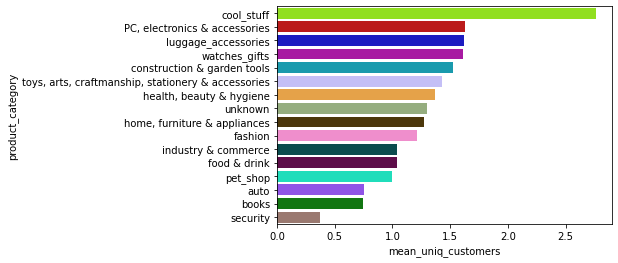

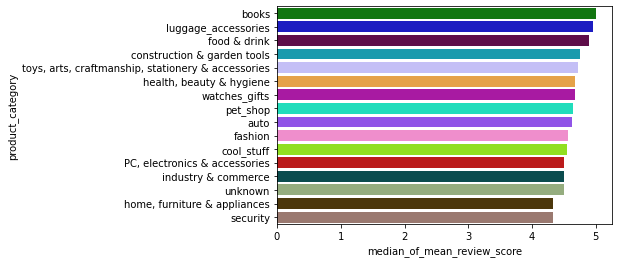

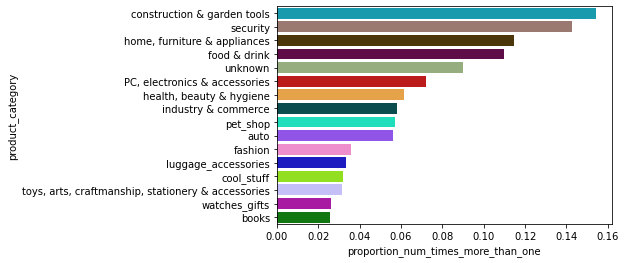

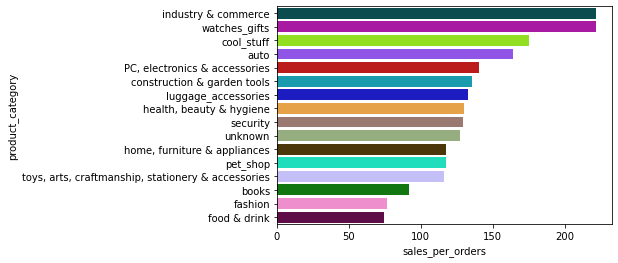

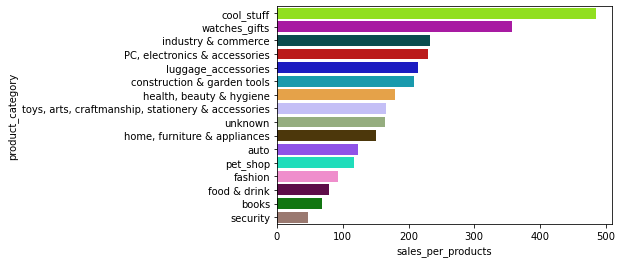

In [132]:
columns = product_agg.columns[1:]

for col in columns:

    y = 'product_category'
    x = col

    sns.barplot(data=product_agg, 
                x=x, 
                y=y,
                palette = dict_color,
                order=product_agg.sort_values(by=x, ascending=False)[y])
    plt.show()

In [76]:
(product_2017_copy['total_sold'] == 1).mean()

0.5664464678926382

In [78]:
(product_2017_copy['num_times_more_than_one'] == 0).mean()

0.8640718919240612

In [79]:
(product_2017_copy['num_uniq_customers'] == 1).mean()

0.6160209486401238